In [1]:
%matplotlib inline

In [2]:
!nvidia-smi

Wed Mar  8 18:31:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8    10W /  60W |      6MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F

In [4]:
%pip install torchsummary
%pip install -U albumentations
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

print('[Train]')
print(' - Numpy shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2))/255.)
print(' - max:', np.max(exp_data, axis=(0,1,2))/255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2))/255.)
print(' - std:', np.std(exp_data, axis=(0,1,2))/255.)
print(' - var:', np.var(exp_data, axis=(0,1,2))/255.)

Files already downloaded and verified
[Train]
 - Numpy shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [6]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = A.Compose([
    A.Normalize(
        mean=(0.49139968, 0.48215841, 0.44653091),
        std=(0.24703223, 0.24348513, 0.26158784),
    ),
    A.HorizontalFlip(),
    A.ShiftScaleRotate(),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215841, 0.44653091), mask_fill_value=None)
])

test_transform = A.Compose([
    A.Normalize(
        mean=[0.49139968, 0.48215841, 0.44653091],
        std=[0.24703223, 0.24348513, 0.26158784],
    )
])

SEED = 69

torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        return torch.tensor(image, dtype=torch.float), label


trainset = Cifar10Dataset(root='./data', train=True,
                                        download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testset = Cifar10Dataset(root='./data', train=False,
                                       download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   car  frog   car


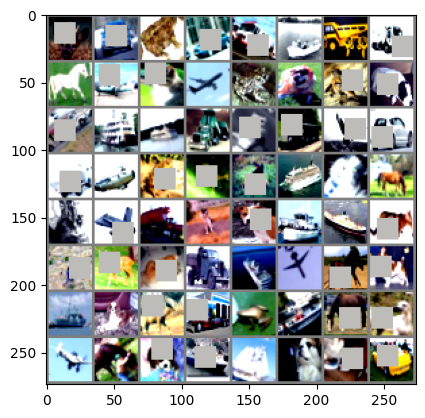

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
from models.model import Net

In [9]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, (3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 15, 15]           9,248
      BatchNorm2d-14           [-1

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimiser):
  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)

    optimiser.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    loss.backward()
    optimiser.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:

      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

EPOCHS = 50

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)

epoch: 0


Loss=1.996768593788147 Batch_id=781 Accuracy=21.57: 100%|██████████| 782/782 [00:12<00:00, 64.70it/s] 



Test set: Average loss: 0.0278, Accuracy: 3176/10000 (31.76%)

epoch: 1


Loss=1.1969563961029053 Batch_id=781 Accuracy=36.93: 100%|██████████| 782/782 [00:11<00:00, 67.90it/s]



Test set: Average loss: 0.0222, Accuracy: 4809/10000 (48.09%)

epoch: 2


Loss=1.0313658714294434 Batch_id=781 Accuracy=44.25: 100%|██████████| 782/782 [00:11<00:00, 68.19it/s]



Test set: Average loss: 0.0214, Accuracy: 4965/10000 (49.65%)

epoch: 3


Loss=1.1906236410140991 Batch_id=781 Accuracy=48.81: 100%|██████████| 782/782 [00:11<00:00, 69.77it/s]



Test set: Average loss: 0.0177, Accuracy: 5938/10000 (59.38%)

epoch: 4


Loss=0.9552145004272461 Batch_id=781 Accuracy=52.21: 100%|██████████| 782/782 [00:11<00:00, 67.93it/s]



Test set: Average loss: 0.0164, Accuracy: 6307/10000 (63.07%)

epoch: 5


Loss=1.5160919427871704 Batch_id=781 Accuracy=55.16: 100%|██████████| 782/782 [00:12<00:00, 62.82it/s]



Test set: Average loss: 0.0153, Accuracy: 6560/10000 (65.60%)

epoch: 6


Loss=1.130090594291687 Batch_id=781 Accuracy=57.56: 100%|██████████| 782/782 [00:11<00:00, 68.71it/s] 



Test set: Average loss: 0.0146, Accuracy: 6715/10000 (67.15%)

epoch: 7


Loss=0.9328476786613464 Batch_id=781 Accuracy=59.21: 100%|██████████| 782/782 [00:12<00:00, 64.40it/s]



Test set: Average loss: 0.0138, Accuracy: 6928/10000 (69.28%)

epoch: 8


Loss=1.0978988409042358 Batch_id=781 Accuracy=60.60: 100%|██████████| 782/782 [00:12<00:00, 61.75it/s]



Test set: Average loss: 0.0131, Accuracy: 7106/10000 (71.06%)

epoch: 9


Loss=1.6396515369415283 Batch_id=781 Accuracy=62.29: 100%|██████████| 782/782 [00:12<00:00, 62.97it/s]



Test set: Average loss: 0.0125, Accuracy: 7284/10000 (72.84%)

epoch: 10


Loss=1.0464117527008057 Batch_id=781 Accuracy=63.09: 100%|██████████| 782/782 [00:12<00:00, 62.87it/s]



Test set: Average loss: 0.0124, Accuracy: 7273/10000 (72.73%)

epoch: 11


Loss=1.1259998083114624 Batch_id=781 Accuracy=64.28: 100%|██████████| 782/782 [00:12<00:00, 63.64it/s]



Test set: Average loss: 0.0119, Accuracy: 7360/10000 (73.60%)

epoch: 12


Loss=0.8709942698478699 Batch_id=781 Accuracy=65.01: 100%|██████████| 782/782 [00:12<00:00, 63.94it/s]



Test set: Average loss: 0.0118, Accuracy: 7424/10000 (74.24%)

epoch: 13


Loss=1.4824378490447998 Batch_id=781 Accuracy=65.66: 100%|██████████| 782/782 [00:12<00:00, 63.01it/s]



Test set: Average loss: 0.0121, Accuracy: 7375/10000 (73.75%)

epoch: 14


Loss=1.9149343967437744 Batch_id=781 Accuracy=66.39: 100%|██████████| 782/782 [00:11<00:00, 67.39it/s]



Test set: Average loss: 0.0109, Accuracy: 7621/10000 (76.21%)

epoch: 15


Loss=1.353268027305603 Batch_id=781 Accuracy=66.77: 100%|██████████| 782/782 [00:11<00:00, 68.48it/s] 



Test set: Average loss: 0.0108, Accuracy: 7619/10000 (76.19%)

epoch: 16


Loss=0.9366323351860046 Batch_id=781 Accuracy=67.58: 100%|██████████| 782/782 [00:11<00:00, 69.22it/s]



Test set: Average loss: 0.0102, Accuracy: 7777/10000 (77.77%)

epoch: 17


Loss=0.7613909244537354 Batch_id=781 Accuracy=68.13: 100%|██████████| 782/782 [00:11<00:00, 68.79it/s]



Test set: Average loss: 0.0107, Accuracy: 7677/10000 (76.77%)

epoch: 18


Loss=0.835288941860199 Batch_id=781 Accuracy=68.41: 100%|██████████| 782/782 [00:11<00:00, 69.91it/s] 



Test set: Average loss: 0.0099, Accuracy: 7841/10000 (78.41%)

epoch: 19


Loss=0.8980985879898071 Batch_id=781 Accuracy=68.78: 100%|██████████| 782/782 [00:11<00:00, 68.61it/s]



Test set: Average loss: 0.0096, Accuracy: 7965/10000 (79.65%)

epoch: 20


Loss=0.7543253302574158 Batch_id=781 Accuracy=69.37: 100%|██████████| 782/782 [00:11<00:00, 68.89it/s]



Test set: Average loss: 0.0096, Accuracy: 7913/10000 (79.13%)

epoch: 21


Loss=1.1987169981002808 Batch_id=781 Accuracy=69.89: 100%|██████████| 782/782 [00:11<00:00, 69.34it/s] 



Test set: Average loss: 0.0095, Accuracy: 7984/10000 (79.84%)

epoch: 22


Loss=1.2468228340148926 Batch_id=781 Accuracy=69.87: 100%|██████████| 782/782 [00:11<00:00, 68.84it/s]



Test set: Average loss: 0.0096, Accuracy: 7929/10000 (79.29%)

epoch: 23


Loss=0.9404059648513794 Batch_id=781 Accuracy=69.93: 100%|██████████| 782/782 [00:11<00:00, 69.32it/s] 



Test set: Average loss: 0.0096, Accuracy: 7932/10000 (79.32%)

epoch: 24


Loss=1.2625857591629028 Batch_id=781 Accuracy=70.74: 100%|██████████| 782/782 [00:11<00:00, 66.45it/s]



Test set: Average loss: 0.0096, Accuracy: 7931/10000 (79.31%)

epoch: 25


Loss=0.6668355464935303 Batch_id=781 Accuracy=70.71: 100%|██████████| 782/782 [00:12<00:00, 61.39it/s] 



Test set: Average loss: 0.0091, Accuracy: 8054/10000 (80.54%)

epoch: 26


Loss=1.1094173192977905 Batch_id=781 Accuracy=71.16: 100%|██████████| 782/782 [00:11<00:00, 66.24it/s]



Test set: Average loss: 0.0088, Accuracy: 8095/10000 (80.95%)

epoch: 27


Loss=0.8858429193496704 Batch_id=781 Accuracy=71.29: 100%|██████████| 782/782 [00:11<00:00, 67.28it/s]



Test set: Average loss: 0.0086, Accuracy: 8164/10000 (81.64%)

epoch: 28


Loss=1.3410041332244873 Batch_id=781 Accuracy=71.56: 100%|██████████| 782/782 [00:11<00:00, 66.03it/s] 



Test set: Average loss: 0.0085, Accuracy: 8180/10000 (81.80%)

epoch: 29


Loss=0.32263079285621643 Batch_id=781 Accuracy=71.60: 100%|██████████| 782/782 [00:11<00:00, 67.89it/s]



Test set: Average loss: 0.0086, Accuracy: 8182/10000 (81.82%)

epoch: 30


Loss=0.9488498568534851 Batch_id=781 Accuracy=71.89: 100%|██████████| 782/782 [00:11<00:00, 69.34it/s] 



Test set: Average loss: 0.0084, Accuracy: 8201/10000 (82.01%)

epoch: 31


Loss=1.1932592391967773 Batch_id=781 Accuracy=72.33: 100%|██████████| 782/782 [00:11<00:00, 68.86it/s] 



Test set: Average loss: 0.0088, Accuracy: 8081/10000 (80.81%)

epoch: 32


Loss=1.4983158111572266 Batch_id=781 Accuracy=72.41: 100%|██████████| 782/782 [00:11<00:00, 68.92it/s]



Test set: Average loss: 0.0084, Accuracy: 8197/10000 (81.97%)

epoch: 33


Loss=0.8279755711555481 Batch_id=781 Accuracy=72.51: 100%|██████████| 782/782 [00:11<00:00, 68.85it/s]



Test set: Average loss: 0.0087, Accuracy: 8129/10000 (81.29%)

epoch: 34


Loss=0.4433937966823578 Batch_id=781 Accuracy=72.66: 100%|██████████| 782/782 [00:11<00:00, 68.50it/s] 



Test set: Average loss: 0.0082, Accuracy: 8255/10000 (82.55%)

epoch: 35


Loss=0.7420388460159302 Batch_id=781 Accuracy=72.77: 100%|██████████| 782/782 [00:11<00:00, 69.28it/s] 



Test set: Average loss: 0.0081, Accuracy: 8281/10000 (82.81%)

epoch: 36


Loss=0.852286159992218 Batch_id=781 Accuracy=73.31: 100%|██████████| 782/782 [00:11<00:00, 68.59it/s]  



Test set: Average loss: 0.0084, Accuracy: 8201/10000 (82.01%)

epoch: 37


Loss=0.7319351434707642 Batch_id=781 Accuracy=73.24: 100%|██████████| 782/782 [00:11<00:00, 68.48it/s] 



Test set: Average loss: 0.0081, Accuracy: 8245/10000 (82.45%)

epoch: 38


Loss=0.7894690036773682 Batch_id=781 Accuracy=73.23: 100%|██████████| 782/782 [00:11<00:00, 67.40it/s] 



Test set: Average loss: 0.0080, Accuracy: 8263/10000 (82.63%)

epoch: 39


Loss=0.9648656249046326 Batch_id=781 Accuracy=73.33: 100%|██████████| 782/782 [00:11<00:00, 67.08it/s] 



Test set: Average loss: 0.0083, Accuracy: 8224/10000 (82.24%)

epoch: 40


Loss=0.4608636796474457 Batch_id=781 Accuracy=73.47: 100%|██████████| 782/782 [00:11<00:00, 69.20it/s] 



Test set: Average loss: 0.0082, Accuracy: 8242/10000 (82.42%)

epoch: 41


Loss=0.5564107894897461 Batch_id=781 Accuracy=73.51: 100%|██████████| 782/782 [00:11<00:00, 68.61it/s] 



Test set: Average loss: 0.0078, Accuracy: 8328/10000 (83.28%)

epoch: 42


Loss=1.2687474489212036 Batch_id=781 Accuracy=73.87: 100%|██████████| 782/782 [00:11<00:00, 69.30it/s] 



Test set: Average loss: 0.0081, Accuracy: 8254/10000 (82.54%)

epoch: 43


Loss=0.5720281600952148 Batch_id=781 Accuracy=74.32: 100%|██████████| 782/782 [00:11<00:00, 68.50it/s] 



Test set: Average loss: 0.0079, Accuracy: 8301/10000 (83.01%)

epoch: 44


Loss=1.8310648202896118 Batch_id=781 Accuracy=74.23: 100%|██████████| 782/782 [00:11<00:00, 68.50it/s] 



Test set: Average loss: 0.0075, Accuracy: 8396/10000 (83.96%)

epoch: 45


Loss=0.8764050602912903 Batch_id=781 Accuracy=73.94: 100%|██████████| 782/782 [00:11<00:00, 69.21it/s] 



Test set: Average loss: 0.0078, Accuracy: 8359/10000 (83.59%)

epoch: 46


Loss=0.6159775257110596 Batch_id=781 Accuracy=74.50: 100%|██████████| 782/782 [00:11<00:00, 68.91it/s] 



Test set: Average loss: 0.0078, Accuracy: 8325/10000 (83.25%)

epoch: 47


Loss=1.1380888223648071 Batch_id=781 Accuracy=74.45: 100%|██████████| 782/782 [00:11<00:00, 69.18it/s] 



Test set: Average loss: 0.0074, Accuracy: 8414/10000 (84.14%)

epoch: 48


Loss=0.7557020783424377 Batch_id=781 Accuracy=74.27: 100%|██████████| 782/782 [00:11<00:00, 68.90it/s] 



Test set: Average loss: 0.0078, Accuracy: 8341/10000 (83.41%)

epoch: 49


Loss=0.8464289307594299 Batch_id=781 Accuracy=74.64: 100%|██████████| 782/782 [00:11<00:00, 68.42it/s] 



Test set: Average loss: 0.0075, Accuracy: 8452/10000 (84.52%)



Text(0.5, 1.0, 'Test Accuracy')

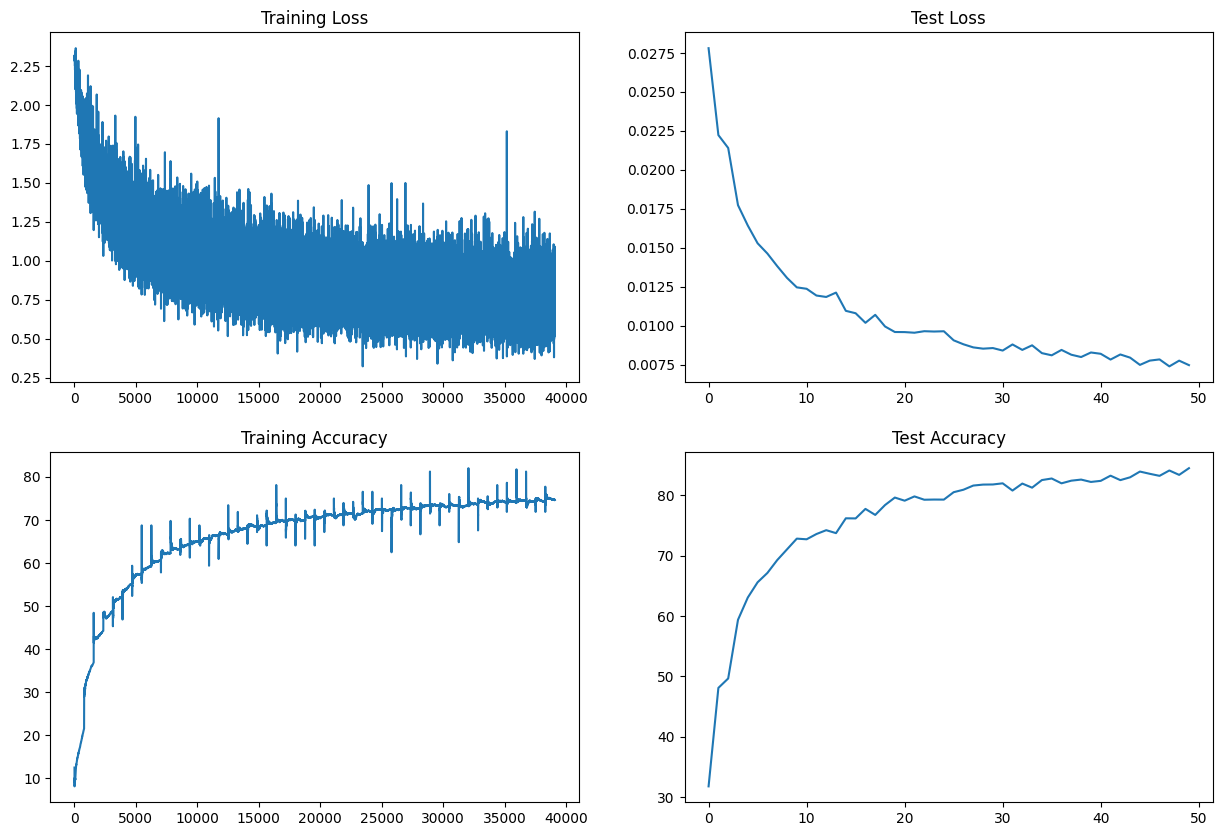

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")